### Wine Categorization with Clustering 

In [ ]:
# imports
import pandas as pd
import seaborn as sbn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from silhouette_plot import silhouette_plot
from sklearn.metrics import davies_bouldin_score

In [4]:
# load in data
wine = pd.read_csv("data/wine.csv")
wine.shape

(178, 13)

### Data Preprocessing
Clean data before processing. 

In [5]:
# fill missing values with median
wine = wine.fillna(wine.median(numeric_only=True))

In [6]:
# detect and remove outliers with IQR
Q1 = wine.quantile(0.25)
Q3 = wine.quantile(0.75)
IQR = Q3 - Q1

# remove outliers
wine_cleaned = wine[
    ~((wine < (Q1 - 1.5 * IQR)) | (wine > (Q3 + 1.5 * IQR))).any(axis=1)
].copy()

### Feature Scaling

In [7]:
# standardize numerical features
scaler = StandardScaler()
X = wine_cleaned[0:]
X_scaled = scaler.fit_transform(X)

### K-Means Clustering 

c:\Users\dorky\anaconda3\envs\CSB320\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\dorky\anaconda3\envs\CSB320\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\dorky\anaconda3\envs\CSB320\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\dorky\anaconda3\envs\CSB320\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning:

<function matplotlib.pyplot.show(close=None, block=None)>

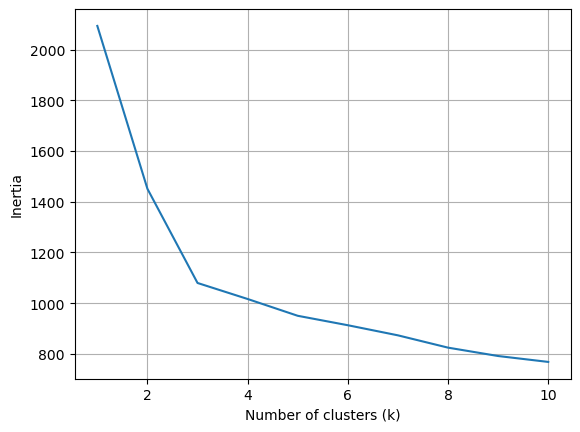

In [8]:
# elbow method to determine optimal number of clusters (k)
# calculate the inertia
inertia = []
K = range(1, 11)

for k in K:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# plot values
plt.plot(K, inertia)
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia")
plt.grid(True)
plt.show

**Inflection point at k = 3 indicates optimal number of clusters**
- This is great, the dataset was obtained from 3 different varietals of wine. 

In [9]:
# train K-means model
kmeans = KMeans(n_clusters=3)
kmeans.fit(X_scaled)

# assign cluster labels
kmeans_labels = kmeans.predict(X_scaled)
wine_cleaned["kmeans_cluster"] = kmeans_labels

c:\Users\dorky\anaconda3\envs\CSB320\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


### Hierarchical Clustering

In [39]:
# apply agglomerative clustering
agg = AgglomerativeClustering(n_clusters=3, linkage="ward")
agg_labels = agg.fit_predict(X_scaled)
wine_cleaned["agg_cluster"] = agg_labels

In [ ]:
# compare cluster assignments
count = pd.crosstab(wine_cleaned["kmeans_cluster"],
                    wine_cleaned["agg_cluster"])
print(count)

agg_cluster      0   1   2
kmeans_cluster            
0               45   0   0
1                6   2  50
2                0  58   0


**Cluster assignments are not very congruent with each other.**
- Only cluster 0 has congruence between the two clustering methods.
- these are the strongest results from trying all 4 linkage strategies, with 'single' being a runner up, where the cluster methods both labeled cluster 0 samples similarly. 

### Evaluation 

c:\Users\dorky\anaconda3\envs\CSB320\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\dorky\anaconda3\envs\CSB320\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\dorky\anaconda3\envs\CSB320\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\dorky\anaconda3\envs\CSB320\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning:

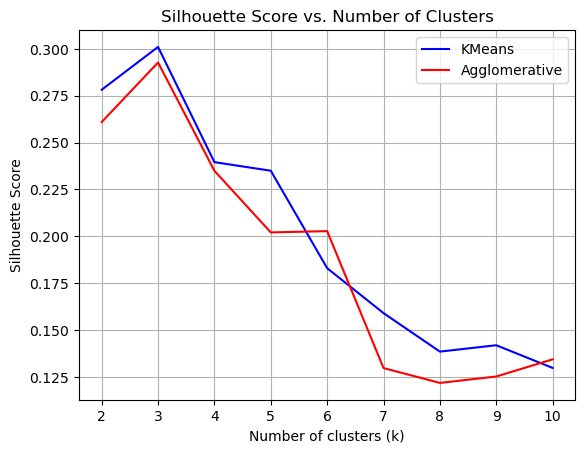

In [12]:
# calculate silhouette scores for different k values
K = range(2, 11)

silhouette_score_kmeans = []
silhouette_score_agg = []

for k in K:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X_scaled)
    k_labels = kmeans.predict(X_scaled)

    agg = AgglomerativeClustering(n_clusters=k, linkage="ward")
    agglo_labels = agg.fit_predict(X_scaled)

    # plot silhouette_score over k
    silhouette_score_kmeans.append(silhouette_score(X_scaled, k_labels))
    silhouette_score_agg.append(silhouette_score(X_scaled, agglo_labels))


plt.figure()
plt.plot(K, silhouette_score_kmeans, label="KMeans", color="blue")
plt.plot(K, silhouette_score_agg, label="Agglomerative", color="red")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score vs. Number of Clusters")
plt.legend()
plt.grid(True)
plt.show()

### Visualization

<Axes: >

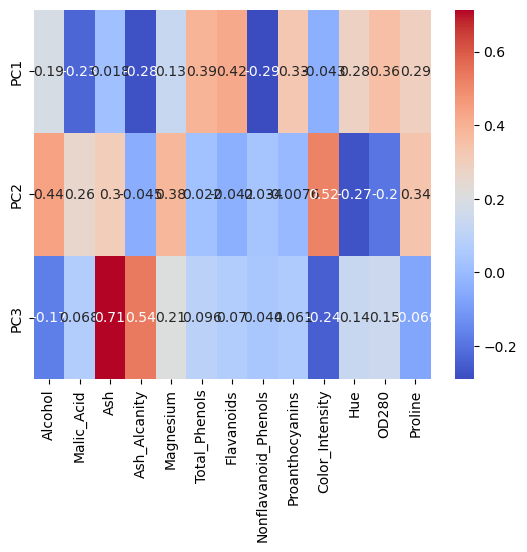

In [41]:
# reduce to 2d with PCA
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

# heatmap of feature importance in PCA components
loadings = pd.DataFrame(pca.components_, columns=X_scaled_df.columns)
sbn.heatmap(
    loadings,
    annot=True,
    cmap="coolwarm",
    xticklabels=X_scaled_df.columns,
    yticklabels=[f"PC{i+1}" for i in range(loadings.shape[0])],
)

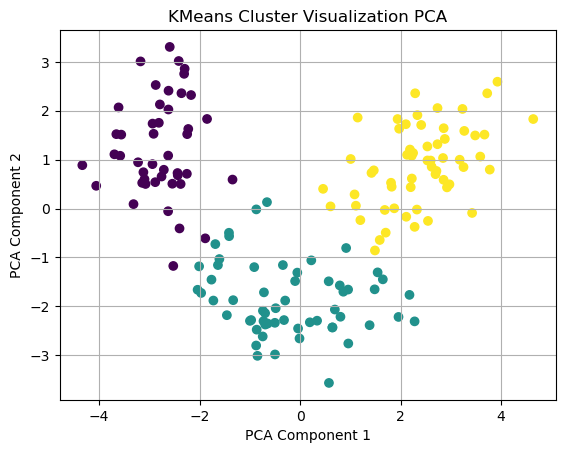

In [42]:
# plot cluster distributions using scatter plots and pair plots
plt.figure()
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("KMeans Cluster Visualization PCA")
plt.grid(True)
plt.show()

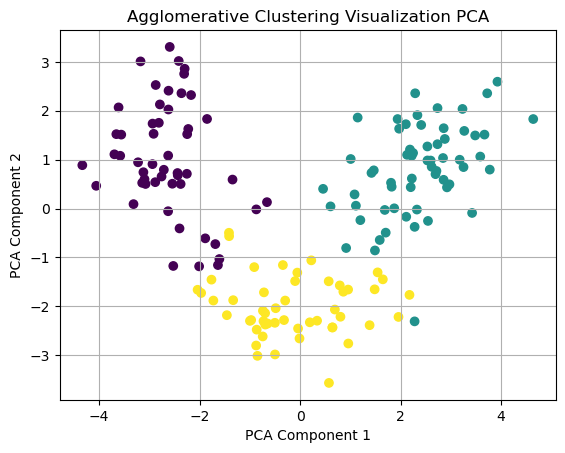

In [43]:
# agglomerative clustering plot
plt.figure()
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=agg_labels)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("Agglomerative Clustering Visualization PCA")
plt.grid(True)
plt.show()

### Silhouette Plots

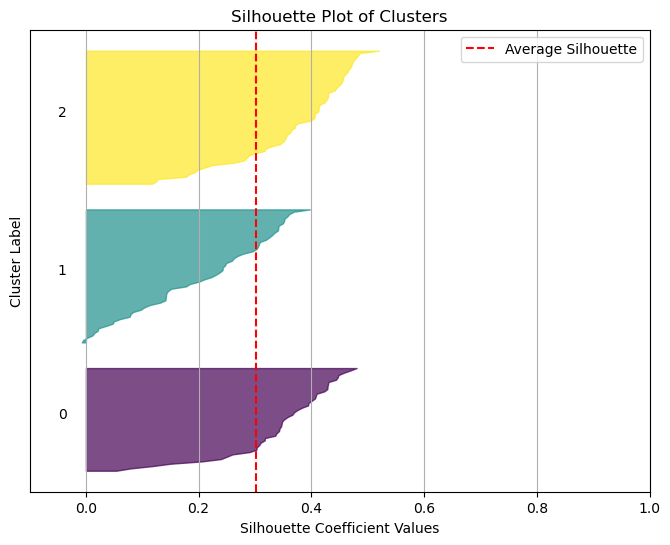

In [44]:
# KMeans Silhouette Plot
silhouette_plot(X_scaled, kmeans_labels)

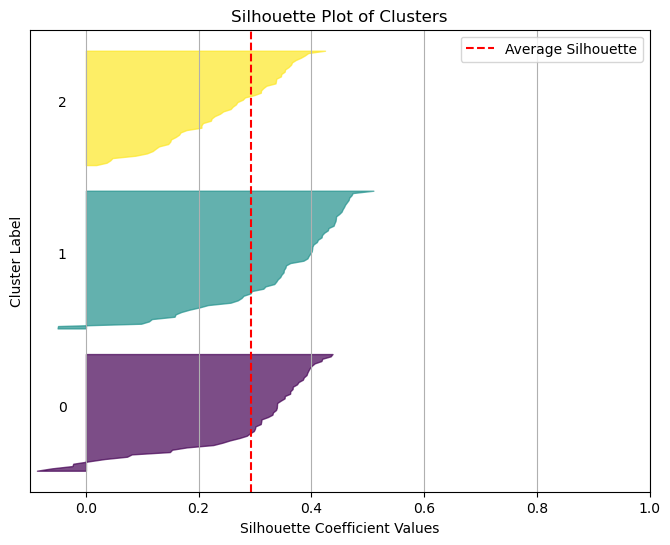

In [45]:
# Agglomerative Silhouette Plot
silhouette_plot(X_scaled, agg_labels)

## Davies-Bouldin Scores

In [46]:
print(f"KMeans: {davies_bouldin_score(X_scaled, kmeans_labels)}")
print(f"Agglomerative: {davies_bouldin_score(X_scaled, agg_labels)}")

KMeans: 1.3011073993472457
Agglomerative: 1.3128645029496349
